Upgrade TFF

In [ ]:
# !pip install --upgrade dp-accounting
# !pip install --upgrade tensorflow-federated

Load Package


In [ ]:
import os
import cv2
import random
import collections

import numpy as np
import pandas as pd

import dp_accounting
import tensorflow as tf
import tensorflow_federated as tff

Mounting to driver to load data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Config Experiment

In [ ]:
# Dataset configuration
num_classes = 5 # Max classes to be processed
min_images_file = 100 # Only proccess Class with images with certain data
train_prop = 0.8 # Split data 80% train, 20% test
min_sample = 5 # Each class has x images on test or training set
max_sample = 99 # Each class has maximum x images on test set
ROOT = "/content/gdrive/My Drive/faces/lfw-deepfunneled" # Root images data located


# Federated learning configuration
batch_size_val = 16
num_clients = 25
all_client_ids = list(range(num_clients))
num_round_val = 25
sampling_client_per_round = 15

### Load Images from Images pool
this code will create train_set and test_set.


*   code will create 2 set data, train_set and test_set


In [ ]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    if image is None:
        print(f'Failed to load image at {path}')
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (128, 128))  # resizing to (128, 128)
    return resized_image

def read_images_from_folders(root_path, min_images=10, max_folders_to_process=None, train_split=0.9):
    label_folders = os.listdir(root_path)
    train_set = []
    test_set = []
    processed_folder_count = 0

    for label_folder in label_folders:
        folder_path = os.path.join(root_path, label_folder)
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

        if len(image_files) >= min_images:
            processed_folder_count += 1
            print(f"Processing folder: {label_folder} with {len(image_files)} images.")
            random.shuffle(image_files)  # Shuffle the images

            # Calculate split index ensuring at least min_sample images in each set
            split_index = max(min_sample, int(len(image_files) * train_split))
            train_images = image_files[:split_index]
            test_images = image_files[split_index:split_index+max_sample]

            for image_file in train_images:
                resized_image = read_image((label_folder, image_file))
                if resized_image is not None:
                    train_set.append((resized_image, label_folder))

            for image_file in test_images:
                resized_image = read_image((label_folder, image_file))
                if resized_image is not None:
                    test_set.append((resized_image, label_folder))

            if max_folders_to_process and processed_folder_count >= max_folders_to_process:
                print(f"Processed {processed_folder_count} folders, stopping as per limit.")
                break

    return train_set, test_set

train_set, test_set = read_images_from_folders(ROOT, min_images=min_images_file, max_folders_to_process=num_classes, train_split=train_prop)

Processing folder: Tony_Blair with 144 images.
Processing folder: George_W_Bush with 530 images.
Processing folder: Gerhard_Schroeder with 109 images.
Processing folder: Colin_Powell with 236 images.
Processing folder: Donald_Rumsfeld with 121 images.
Processed 5 folders, stopping as per limit.


### [Not Main Code] Shows distribution of images number on train_set and test_set



*   we will limit number of class to 10. [less complexity to compute]



In [ ]:
from collections import defaultdict

def get_class_distribution_from_set(dataset):
    # Dictionary to hold the class distribution
    class_distribution = defaultdict(int)

    # Count occurrences of each class
    for _, label in dataset:
        # Convert label to string and decode if necessary
        label_str = label.decode('utf-8') if isinstance(label, bytes) else label
        class_distribution[label_str] += 1

    return class_distribution

# Usage
class_distribution_set = get_class_distribution_from_set(train_set)

# Print the number of images for each class
print("Class distribution in train_set:")
for class_name, count in class_distribution_set.items():
    print(f"  {class_name}: {count}")

class_distribution_set = get_class_distribution_from_set(test_set)
# Print the number of images for each class
print("Class distribution in test_set:")
for class_name, count in class_distribution_set.items():
    print(f"  {class_name}: {count}")


Class distribution in train_set:
  Tony_Blair: 115
  George_W_Bush: 424
  Gerhard_Schroeder: 87
  Colin_Powell: 188
  Donald_Rumsfeld: 96
Class distribution in test_set:
  Tony_Blair: 29
  George_W_Bush: 99
  Gerhard_Schroeder: 22
  Colin_Powell: 48
  Donald_Rumsfeld: 25


### Distribute image to clients follow non-iid scenario

*   each client will get certain images from train_set for each class
*   and also each client will get certain images from test_set for each class as well
*  clients id will selected randomly which images that will be predominant and non pre-dominant




In [ ]:
import random
from collections import defaultdict

def distribute_images_to_clients_non_iid(train_set, num_clients):
    # Group images by class
    images_by_class = defaultdict(list)
    for image, label in train_set:
        images_by_class[label].append(image)

    # Initialize the clients' data
    clients_data = {client_id: [] for client_id in range(num_clients)}

    # Distribute the images to clients
    for client_id in range(num_clients):
        # Select a subset of classes to be predominant for this client
        predominant_classes = random.sample(images_by_class.keys(), k=random.randint(1, len(images_by_class) // 2))

        for label, images in images_by_class.items():
            # Determine the number of images to sample for this class
            if label in predominant_classes:
                # Predominant classes get more images
                num_images_to_sample = random.randint(50, 100)
            else:
                # Non-predominant classes get fewer images
                num_images_to_sample = random.randint(10, 30)

            num_images_to_sample = min(num_images_to_sample, len(images))
            selected_images = random.sample(images, num_images_to_sample)

            # Add selected images to the client's data
            for img in selected_images:
                clients_data[client_id].append((img, label))

    return clients_data

In [ ]:
#parameter num_clients see config above
clients_data_non_iid = distribute_images_to_clients_non_iid(train_set, num_clients)

<ipython-input-7-a987e4142222>:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  predominant_classes = random.sample(images_by_class.keys(), k=random.randint(1, len(images_by_class) // 2))


### [Not Main Code] Check object type and print clients ids



In [ ]:
type(clients_data_non_iid) #ensure this should be dictinoary

dict

In [ ]:
# print random clients id
import random
key, value = random.choice(list(clients_data_non_iid.items()))
print("Sample key:", key)

Sample key: 7


In [ ]:
print("Sample value:", value) # print data, in this stage data supposed to no scaled yet

Sample value: [(array([[[246, 235, 218],
        [246, 234, 218],
        [248, 236, 220],
        ...,
        [ 89,  72,  56],
        [ 87,  71,  55],
        [ 84,  68,  52]],

       [[247, 235, 219],
        [247, 235, 219],
        [249, 236, 221],
        ...,
        [ 90,  73,  57],
        [ 88,  72,  56],
        [ 89,  73,  57]],

       [[248, 236, 219],
        [247, 236, 219],
        [249, 237, 221],
        ...,
        [ 89,  72,  56],
        [ 88,  71,  56],
        [ 88,  72,  56]],

       ...,

       [[ 56,  41,  44],
        [ 59,  44,  47],
        [ 62,  47,  50],
        ...,
        [ 66,  49,  51],
        [ 70,  54,  55],
        [ 73,  57,  58]],

       [[ 57,  42,  45],
        [ 61,  46,  49],
        [ 64,  49,  52],
        ...,
        [ 64,  48,  51],
        [ 69,  53,  56],
        [ 71,  55,  58]],

       [[ 62,  47,  50],
        [ 64,  49,  52],
        [ 66,  51,  54],
        ...,
        [ 63,  47,  50],
        [ 70,  54,  57],
        

### [Not Main Code] ensuring images data distribution on each class each clients


In [ ]:
# Select 3 random clients
random_clients = random.sample(range(num_clients), 3)

# For each random client, count and display the number of images per class
for client_id in random_clients:
    print(f"Client {client_id}:")

    # Count images by class for the client
    class_counts = defaultdict(int)
    for image, label in clients_data_non_iid[client_id]:
        class_counts[label] += 1

    # Display the counts
    for label, count in class_counts.items():
        print(f"    Class {label}: {count} images")
    print()  # Blank line for better readability


Client 21:
    Class Tony_Blair: 10 images
    Class George_W_Bush: 24 images
    Class Gerhard_Schroeder: 26 images
    Class Colin_Powell: 18 images
    Class Donald_Rumsfeld: 88 images

Client 1:
    Class Tony_Blair: 14 images
    Class George_W_Bush: 18 images
    Class Gerhard_Schroeder: 50 images
    Class Colin_Powell: 21 images
    Class Donald_Rumsfeld: 18 images

Client 7:
    Class Tony_Blair: 50 images
    Class George_W_Bush: 24 images
    Class Gerhard_Schroeder: 15 images
    Class Colin_Powell: 28 images
    Class Donald_Rumsfeld: 17 images



### [Not Main Code] ensuring data shape

In [ ]:
import random

# Select one random client
random_client_id = random.choice(list(clients_data_non_iid.keys()))

# Select one random image-label pair from this client's data
random_image, random_label = random.choice(clients_data_non_iid[random_client_id])

# Display information about the selected sample
print(f"Randomly selected client: {random_client_id}")
print(f"Randomly selected label: {random_label}")
print(f"Randomly selected image shape: {random_image.shape}")  # Assuming it's a NumPy array or similar

# If you want to display the image, you'll need additional code depending on your environment
# For example, in a Jupyter notebook, you could use matplotlib:
# import matplotlib.pyplot as plt
# plt.imshow(random_image, cmap='gray')  #


Randomly selected client: 4
Randomly selected label: George_W_Bush
Randomly selected image shape: (128, 128, 3)


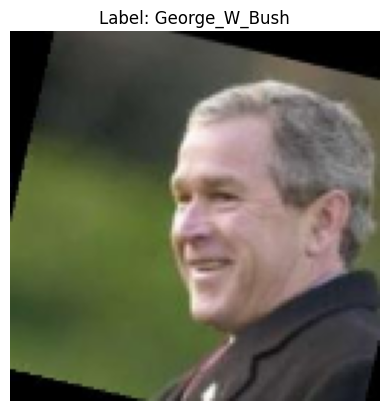

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(random_image)
plt.title(f"Label: {random_label}")
plt.axis('off')  # To turn off the axis
plt.show()

### Create Tensorflow-federated enviroment data for CLIENTS

In [ ]:
import tensorflow as tf

def normalize_image(image):
    return image / 255.0

import tensorflow as tf

def normalize_image(image):
    return image / 255.0

def create_tf_dataset_for_client(client_data, label_to_index, num_classes):
    client_images, client_labels = zip(*client_data)

    # Normalize images
    client_images_normalized = [normalize_image(img) for img in client_images]

    # Convert labels to integer indices and one-hot encode
    client_labels_indices = [label_to_index[label] for label in client_labels]
    client_labels_one_hot = tf.one_hot(client_labels_indices, depth=num_classes)

    # Print distinct labels and their one-hot encodings
    distinct_labels = set(client_labels)
    print("Distinct Labels Before Encoding:", distinct_labels)
    print("Distinct Labels After One-Hot Encoding:")
    for label in distinct_labels:
        index = label_to_index[label]
        one_hot = tf.one_hot(index, depth=num_classes).numpy()
        print(f"  {label} (index: {index}): {one_hot}")

    # Convert to tensor
    client_images_tensor = tf.convert_to_tensor(client_images_normalized)
    client_dataset = tf.data.Dataset.from_tensor_slices((client_images_tensor, client_labels_one_hot))

    # Set an appropriate batch size
    batch_size = 16
    return client_dataset.batch(batch_size)


# Assuming 'train_set' contains all your training data
train_images, train_labels = zip(*train_set)
label_to_index = {label: index for index, label in enumerate(set(train_labels))}
num_classes = len(label_to_index)

# Creating a tf.data.Dataset for each client
client_dataset_tff = {client_id: create_tf_dataset_for_client(data, label_to_index, num_classes)
                      for client_id, data in clients_data_non_iid.items()}


Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (index: 1): [0. 1. 0. 0. 0.]
  George_W_Bush (index: 2): [0. 0. 1. 0. 0.]
  Colin_Powell (index: 3): [0. 0. 0. 1. 0.]
  Gerhard_Schroeder (index: 4): [0. 0. 0. 0. 1.]
Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (index: 1): [0. 1. 0. 0. 0.]
  George_W_Bush (index: 2): [0. 0. 1. 0. 0.]
  Colin_Powell (index: 3): [0. 0. 0. 1. 0.]
  Gerhard_Schroeder (index: 4): [0. 0. 0. 0. 1.]
Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (in

### [Not Main Code] check client_dataset_tff is that already ift as tf environment

In [ ]:
client_dataset_tff

{0: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 1: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 2: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 3: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 4: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 5: <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 6: <_BatchDataset element_spec=(T

In [ ]:
# Print out the keys
print(client_dataset_tff.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])


In [ ]:
# Assuming 'client_dataset_tff' is your federated dataset
client_id = list(client_dataset_tff.keys())[0]  # Take the first client as an example
example_dataset = client_dataset_tff[client_id]

# Inspect the first batch
for example_batch in example_dataset.take(1):
    print("Feature shape:", example_batch[0].shape)
    print("Label shape:", example_batch[1].shape)


Feature shape: (16, 128, 128, 3)
Label shape: (16, 5)


In [ ]:
client_id = 0
example_dataset = client_dataset_tff[client_id]
# Let's take a look at the first element of the example_dataset
for example_element in example_dataset.take(1):
    print(example_element)

(<tf.Tensor: shape=(16, 128, 128, 3), dtype=float64, numpy=
array([[[[0.78823529, 0.71764706, 0.63921569],
         [0.79215686, 0.72156863, 0.64313725],
         [0.79215686, 0.72156863, 0.64313725],
         ...,
         [0.11372549, 0.09803922, 0.01176471],
         [0.0745098 , 0.04705882, 0.00392157],
         [0.0745098 , 0.05490196, 0.04313725]],

        [[0.78823529, 0.71764706, 0.63921569],
         [0.79607843, 0.7254902 , 0.64705882],
         [0.79607843, 0.7254902 , 0.64313725],
         ...,
         [0.14901961, 0.1254902 , 0.05098039],
         [0.0627451 , 0.03921569, 0.00392157],
         [0.0745098 , 0.05490196, 0.04313725]],

        [[0.78431373, 0.71372549, 0.63529412],
         [0.79607843, 0.7254902 , 0.64705882],
         [0.8       , 0.72941176, 0.65098039],
         ...,
         [0.18431373, 0.16078431, 0.10196078],
         [0.0627451 , 0.03529412, 0.00784314],
         [0.07843137, 0.05882353, 0.04705882]],

        ...,

        [[0.31764706, 0.29411765

In [ ]:
# Let's take a closer look at the first element of the example_dataset
for example_element in example_dataset.take(1):
    # The first element is a dictionary with class labels
    label_dict = example_element[0]
    # The second element is the image tensor
    image_tensor = example_element[1]

    # You can now print the label and image data
    print("Label dictionary:", label_dict)
    print("Image tensor:", image_tensor)


Label dictionary: tf.Tensor(
[[[[0.78823529 0.71764706 0.63921569]
   [0.79215686 0.72156863 0.64313725]
   [0.79215686 0.72156863 0.64313725]
   ...
   [0.11372549 0.09803922 0.01176471]
   [0.0745098  0.04705882 0.00392157]
   [0.0745098  0.05490196 0.04313725]]

  [[0.78823529 0.71764706 0.63921569]
   [0.79607843 0.7254902  0.64705882]
   [0.79607843 0.7254902  0.64313725]
   ...
   [0.14901961 0.1254902  0.05098039]
   [0.0627451  0.03921569 0.00392157]
   [0.0745098  0.05490196 0.04313725]]

  [[0.78431373 0.71372549 0.63529412]
   [0.79607843 0.7254902  0.64705882]
   [0.8        0.72941176 0.65098039]
   ...
   [0.18431373 0.16078431 0.10196078]
   [0.0627451  0.03529412 0.00784314]
   [0.07843137 0.05882353 0.04705882]]

  ...

  [[0.31764706 0.29411765 0.34117647]
   [0.30980392 0.29019608 0.3372549 ]
   [0.30196078 0.27843137 0.3254902 ]
   ...
   [0.27058824 0.23137255 0.26666667]
   [0.19607843 0.15686275 0.19215686]
   [0.11764706 0.09019608 0.12156863]]

  [[0.30196078 0

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = batch_size_val
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
    def batch_format_fn(image, label_one_hot):
        return collections.OrderedDict(
            x=image,
            y=label_one_hot
        )

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

# Now you can apply this preprocessing function to your dataset
preprocessed_example_dataset = preprocess(example_dataset)

In [ ]:
print(next(iter(example_dataset.take(1))))

(<tf.Tensor: shape=(16, 128, 128, 3), dtype=float64, numpy=
array([[[[0.78823529, 0.71764706, 0.63921569],
         [0.79215686, 0.72156863, 0.64313725],
         [0.79215686, 0.72156863, 0.64313725],
         ...,
         [0.11372549, 0.09803922, 0.01176471],
         [0.0745098 , 0.04705882, 0.00392157],
         [0.0745098 , 0.05490196, 0.04313725]],

        [[0.78823529, 0.71764706, 0.63921569],
         [0.79607843, 0.7254902 , 0.64705882],
         [0.79607843, 0.7254902 , 0.64313725],
         ...,
         [0.14901961, 0.1254902 , 0.05098039],
         [0.0627451 , 0.03921569, 0.00392157],
         [0.0745098 , 0.05490196, 0.04313725]],

        [[0.78431373, 0.71372549, 0.63529412],
         [0.79607843, 0.7254902 , 0.64705882],
         [0.8       , 0.72941176, 0.65098039],
         ...,
         [0.18431373, 0.16078431, 0.10196078],
         [0.0627451 , 0.03529412, 0.00784314],
         [0.07843137, 0.05882353, 0.04705882]],

        ...,

        [[0.31764706, 0.29411765

In [ ]:
preprocessed_example_dataset.element_spec

OrderedDict([('x',
              TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))])

### Choose your Architecture Model

*   Hybrid CNN Transformer Selected



In [ ]:
# #using cnn
# dropout_rate =0.2
# def create_keras_model():
#     return tf.keras.models.Sequential([
#         tf.keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
#         # tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Activation('relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Dropout(dropout_rate),  # Dropout layer added

#         tf.keras.layers.Conv2D(64, (3, 3)),
#         # tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Activation('relu'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Dropout(dropout_rate),  # Dropout layer added

#         tf.keras.layers.Conv2D(64, (3, 3)),
#         # tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Activation('relu'),
#         tf.keras.layers.Flatten(),

#         tf.keras.layers.Dense(64),
#         # tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Activation('relu'),
#         tf.keras.layers.Dropout(dropout_rate),  # Dropout layer added

#         tf.keras.layers.Dense(len(label_to_index), activation='softmax')
#     ])

# def model_fn():
#     keras_model = create_keras_model()
#     return tff.learning.models.from_keras_model(
#         keras_model,
#         input_spec=preprocessed_example_dataset.element_spec,  # Make sure this matches your dataset spec
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=[tf.keras.metrics.Accuracy()]
#     )


In [ ]:
#using hybrid cnn transfromer based complex version
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Input, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.models import Model

# Transformer block
def transformer_block(inputs, num_heads, ff_dim, rate=0.5):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim * 2, activation="relu")(out1)  # Increased dimensionality
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Model building function
def cnn_transformer_model(input_shape, num_heads, ff_dim, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(inputs)  # Increased filters
    x = Conv2D(128, (3, 3), activation='relu')(x)  # Additional layer
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)  # Additional layer
    x = Flatten()(x)
    x = Reshape((-1, x.shape[-1]))(x)
    x = transformer_block(x, num_heads, ff_dim)
    x = transformer_block(x, num_heads, ff_dim)  # Additional transformer block
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)  # Larger dense layer
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def model_fn():
    # Define your model parameters
    input_shape = (128, 128, 3)  # Replace with the actual shape of your input images
    num_heads = 3  # Number of attention heads in the transformer block
    ff_dim = 64   # Dimensionality of the inner layer of the feed-forward networks in the transformer block
    num_classes = len(label_to_index)  # Number of classes, replace with your actual number of classes

    # Create the model using the cnn_transformer_model function with the correct parameters
    keras_model = cnn_transformer_model(input_shape, num_heads, ff_dim, num_classes)

    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_dataset.element_spec,  # Make sure this matches your dataset spec
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.Accuracy()]
    )


In [ ]:
# # #using hybrid cnn transfromer based lite version
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Input, Conv2D, MaxPooling2D, Flatten, Reshape
# from tensorflow.keras.models import Model

# # Simplified Transformer block
# def transformer_block(inputs, num_heads, ff_dim, rate=0.1):
#     attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
#     attn_output = Dropout(rate)(attn_output)
#     out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
#     return out1

# # Simplified Model building function
# def cnn_transformer_model(input_shape, num_heads, ff_dim, num_classes):
#     inputs = Input(shape=input_shape)
#     x = Conv2D(32, (3, 3), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(128, (3, 3), activation='relu')(x)
#     x = Flatten()(x)
#     x = Reshape((-1, x.shape[-1]))(x)
#     x = transformer_block(x, num_heads, ff_dim)
#     x = GlobalAveragePooling1D()(x)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(0.1)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# def model_fn():
#     input_shape = (128, 128, 3)  # Replace with the actual shape of your input images
#     num_heads = 2  # Reduced number of attention heads
#     ff_dim = 32   # Reduced dimensionality of the feed-forward networks
#     num_classes = len(label_to_index)  # Number of classes

#     keras_model = cnn_transformer_model(input_shape, num_heads, ff_dim, num_classes)

#     return tff.learning.models.from_keras_model(
#         keras_model,
#         input_spec=preprocessed_example_dataset.element_spec,
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=[tf.keras.metrics.Accuracy()]
#     )

### Choose Aggregation function

*   FedProx selected


In [ ]:
#using fedavg
# training_process = tff.learning.algorithms.build_weighted_fed_avg(
#     model_fn,
#     client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
#     server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.9))

# using fedprox
training_process = tff.learning.algorithms.build_weighted_fed_prox(
    model_fn=model_fn,
    proximal_strength=0.2,  # This is the strength of the proximal term, adjust as needed
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)
    # Add additional parameters as needed, such as client_weighting, model_distributor, etc.
)


In [ ]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[3,3,3,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[3,3,64,128],
      float32[128],
      float32[100352,2,64],
      float32[2,64],
      float32[100352,2,64],
      float32[2,64],
      float32[100352,2,64],
      float32[2,64],
      float32[2,64,100352],
      float32[100352],
      float32[100352],
      float32[100352],
      float32[100352,64],
      float32[64],
      float32[64,100352],
      float32[100352],
      float32[100352],
      float32[100352],
      float32[100352,64],
      float32[64],
      float32[64,5],
      float32[5]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[3,3,3,32],
    float32[32],
    float32[3,3,32,64],
    float32[64],
    float32[3,3,64,128],
    float32[128],
    float32[100352,2,64],
    float32[2,64],
    float32[10

### Initializing FedLearning


In [ ]:
state = training_process.initialize()

In [ ]:
client_ids = list(client_dataset_tff.keys())
def get_federated_train_data(client_ids):
    return [
        client_dataset_tff[client_id]
        for client_id in client_ids
    ]

Looping per round [care it would crash if you running for many round, required high ram. Atleast you need have 32 GB RAM

 if you afraid let using below code that running per round manually.

In [ ]:
# import random

# NUM_ROUNDS = 10  # Number of training rounds
# NUM_CLIENTS_PER_ROUND = 5  # Number of clients to sample per round

# for round_num in range(1, NUM_ROUNDS + 1):
#     # Randomly sample a subset of client IDs
#     sampled_client_ids = random.sample(all_client_ids, NUM_CLIENTS_PER_ROUND)

#     # Get the federated dataset for the sampled clients
#     federated_train_data = get_federated_train_data(sampled_client_ids)

#     # Perform a training round with the sampled clients
#     state, metrics = training_process.next(state, federated_train_data)
#     print(f'Round {round_num:2d}, Metrics: {metrics}')


Benefits of Client Sampling:
Scalability: More manageable and scalable, especially with a large number of clients.
Realism: Mimics real-world scenarios where not all clients can participate at the same time.
Data Diversity: Helps the model to learn from a wider range of data distributions, especially if client data is non-IID (not identically and independently distributed).
Client sampling is a key aspect of practical federated learning implementations, helping to manage resources and data variability effectively.

### Running per round manually

In [ ]:
def perform_training_round(round_num, state, all_client_ids, NUM_CLIENTS_PER_ROUND, get_federated_train_data, training_process):
    print(f"Starting training round {round_num}...")

    # Randomly sample a subset of client IDs
    sampled_client_ids = random.sample(all_client_ids, NUM_CLIENTS_PER_ROUND)

    # Get the federated dataset for the sampled clients
    federated_train_data = get_federated_train_data(sampled_client_ids)

    # Perform a training round with the sampled clients
    state, metrics = training_process.next(state, federated_train_data)

    print(f'Round {round_num:2d}, Metrics: {metrics}')
    return state


In [ ]:
import time

def perform_training_round(round_num, state, all_client_ids, NUM_CLIENTS_PER_ROUND, get_federated_train_data, training_process):
    print(f"Starting training round {round_num}...")

    start_time = time.time()  # Time tracking starts

    # Randomly sample a subset of client IDs
    sampled_client_ids = random.sample(all_client_ids, NUM_CLIENTS_PER_ROUND)

    # Get the federated dataset for the sampled clients
    federated_train_data = get_federated_train_data(sampled_client_ids)

    # Perform a training round with the sampled clients
    state, metrics = training_process.next(state, federated_train_data)

    end_time = time.time()  # Time tracking ends

    # Calculate and print the duration of the round
    duration = end_time - start_time
    print(f'Round {round_num:2d} completed. Duration: {duration:.2f} seconds. Metrics: {metrics}')

    return state

# Example of executing the training rounds
NUM_ROUNDS = num_round_val  # Total number of training rounds
NUM_CLIENTS_PER_ROUND = sampling_client_per_round  # Number of clients to sample per round
all_client_ids = list(range(num_clients))  # Assuming client IDs are 0, 1, 2, ..., N-1

# Initialize the training state
state = training_process.initialize()

# Run the training rounds
for current_round in range(1, NUM_ROUNDS + 1):
    state = perform_training_round(current_round, state, all_client_ids, NUM_CLIENTS_PER_ROUND, get_federated_train_data, training_process)


Starting training round 1...
Round  1 completed. Duration: 139.50 seconds. Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('accuracy', 0.41541284), ('loss', 10.436529), ('num_examples', 2725), ('num_batches', 176)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Starting training round 2...
Round  2 completed. Duration: 129.81 seconds. Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('accuracy', 0.6524649), ('loss', 10.745913), ('num_examples', 2779), ('num_batches', 180)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Starting training round 3...
Round  3 completed. Duration: 118.56 seconds. Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('accuracy', 0.85932004), ('loss', 

Additional Round

### Prepared Testing data
so bassically testing is also been tested on each client, so either training or test all accuracy, loss is an aggregation based on selected clients who selected. However, for testing will be conducted for all clients using global models.

In [ ]:
def distribute_test_data_to_clients(test_set, num_clients):
    images_by_class = defaultdict(list)
    for image, label in test_set:
        images_by_class[label].append(image)

    clients_test_data = {client_id: [] for client_id in range(num_clients)}

    for client_id in range(num_clients):
        predominant_classes = random.sample(images_by_class.keys(), k=random.randint(1, len(images_by_class) // 2))

        for label, images in images_by_class.items():
            num_images_to_sample = random.randint(2, 5) if label in predominant_classes else random.randint(5, 10)
            num_images_to_sample = min(num_images_to_sample, len(images))
            selected_images = random.sample(images, num_images_to_sample)

            for img in selected_images:
                clients_test_data[client_id].append((img, label))

    return clients_test_data

In [ ]:
def preprocess_client_test_data(client_test_data, label_to_index, num_classes):
    client_images, client_labels = zip(*client_test_data)

    # Normalize images
    client_images_normalized = [normalize_image(img) for img in client_images]

    # Convert labels to integer indices and one-hot encode
    client_labels_indices = [label_to_index[label] for label in client_labels]
    client_labels_one_hot = tf.one_hot(client_labels_indices, depth=num_classes)

    # Print distinct labels and their one-hot encodings
    distinct_labels = set(client_labels)
    print("Distinct Labels Before Encoding:", distinct_labels)
    print("Distinct Labels After One-Hot Encoding:")
    for label in distinct_labels:
        index = label_to_index[label]
        one_hot = tf.one_hot(index, depth=num_classes).numpy()
        print(f"  {label} (index: {index}): {one_hot}")

    # Convert to tensor
    client_images_tensor = tf.convert_to_tensor(client_images_normalized)
    client_dataset = tf.data.Dataset.from_tensor_slices((client_images_tensor, client_labels_one_hot))

    # Set an appropriate batch size
    batch_size = batch_size_val
    return client_dataset.batch(batch_size)


In [ ]:
# Distribute the test set among clients
clients_test_data_non_iid = distribute_test_data_to_clients(test_set, num_clients)

# Preprocess each client's test data
federated_test_data = [preprocess_client_test_data(data, label_to_index, num_classes)
                       for data in clients_test_data_non_iid.values()]


Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (index: 1): [0. 1. 0. 0. 0.]
  George_W_Bush (index: 2): [0. 0. 1. 0. 0.]
  Colin_Powell (index: 3): [0. 0. 0. 1. 0.]
  Gerhard_Schroeder (index: 4): [0. 0. 0. 0. 1.]


<ipython-input-34-8a3e79eca175>:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  predominant_classes = random.sample(images_by_class.keys(), k=random.randint(1, len(images_by_class) // 2))


Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (index: 1): [0. 1. 0. 0. 0.]
  George_W_Bush (index: 2): [0. 0. 1. 0. 0.]
  Colin_Powell (index: 3): [0. 0. 0. 1. 0.]
  Gerhard_Schroeder (index: 4): [0. 0. 0. 0. 1.]
Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (index: 1): [0. 1. 0. 0. 0.]
  George_W_Bush (index: 2): [0. 0. 1. 0. 0.]
  Colin_Powell (index: 3): [0. 0. 0. 1. 0.]
  Gerhard_Schroeder (index: 4): [0. 0. 0. 0. 1.]
Distinct Labels Before Encoding: {'Tony_Blair', 'Donald_Rumsfeld', 'George_W_Bush', 'Colin_Powell', 'Gerhard_Schroeder'}
Distinct Labels After One-Hot Encoding:
  Tony_Blair (index: 0): [1. 0. 0. 0. 0.]
  Donald_Rumsfeld (in

Checking test data is formatted correctly

In [ ]:
client_id = 0
example_dataset = federated_test_data[client_id]
# Let's take a look at the first element of the example_dataset
for example_element in example_dataset.take(1):
    print(example_element)

(<tf.Tensor: shape=(16, 128, 128, 3), dtype=float64, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00784314, 0.        , 0.01176471],
         [0.00784314, 0.        , 0.01176471],
         [0.00784314, 0.        , 0.01176471]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ]],

        ...,

        [[0.        , 0.        

Initialize testing data

In [ ]:
# Initialize the evaluation process and state
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = evaluation_process.initialize()

In [ ]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[3,3,3,32],
        float32[32],
        float32[3,3,32,64],
        float32[64],
        float32[3,3,64,128],
        float32[128],
        float32[100352,2,64],
        float32[2,64],
        float32[100352,2,64],
        float32[2,64],
        float32[100352,2,64],
        float32[2,64],
        float32[2,64,100352],
        float32[100352],
        float32[100352],
        float32[100352],
        float32[100352,64],
        float32[64],
        float32[64,100352],
        float32[100352],
        float32[100352],
        float32[100352],
        float32[100352,64],
        float32[64],
        float32[64,5],
        float32[5]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        accuracy=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_

Evaluate global model on each clients

In [ ]:
# Set model weights for evaluation
model_weights = training_process.get_model_weights(state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

# Perform evaluation with the federated test data
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

In [ ]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('accuracy', 0.8965811), ('loss', 9.854431), ('num_examples', 805), ('num_batches', 60)])), ('total_rounds_metrics', OrderedDict([('accuracy', 0.8965811), ('loss', 9.854431), ('num_examples', 805), ('num_batches', 60)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

Appendix Illustration

# Federated Learning: Accuracy Calculation Example

In this example, we demonstrate how accuracy is calculated in a federated learning setup with 3 clients and 3 classes. Each client processes a certain number of batches, and we know the number of correct predictions in each batch.

## Setup

- **Clients**: 3 (Client A, Client B, Client C)
- **Classes**: 3
- **Batches**: 2 batches per client
- **Batch Size**: 10 samples per batch

## Client Data

- **Client A**:
  - Batch 1: 6 correct out of 10
  - Batch 2: 7 correct out of 10
- **Client B**:
  - Batch 1: 5 correct out of 10
  - Batch 2: 8 correct out of 10
- **Client C**:
  - Batch 1: 7 correct out of 10
  - Batch 2: 4 correct out of 10

## Step-by-Step Calculation

1. **Calculate Batch Accuracies**:
   - Client A, Batch 1 Accuracy: 6/10 = 0.6
   - Client A, Batch 2 Accuracy: 7/10 = 0.7
   - Client B, Batch 1 Accuracy: 5/10 = 0.5
   - Client B, Batch 2 Accuracy: 8/10 = 0.8
   - Client C, Batch 1 Accuracy: 7/10 = 0.7
   - Client C, Batch 2 Accuracy: 4/10 = 0.4

2. **Average Accuracy per Client**:
   - Client A's Average Accuracy: (0.6 + 0.7) / 2 = 0.65
   - Client B's Average Accuracy: (0.5 + 0.8) / 2 = 0.65
   - Client C's Average Accuracy: (0.7 + 0.4) / 2 = 0.55

3. **Aggregate Accuracy Across Clients**:
   - Overall Average Accuracy: (Client A's Average + Client B's Average + Client C's Average) / Number of Clients
   - Overall Average Accuracy: (0.65 + 0.65 + 0.55) / 3 = 0.6167

The overall average accuracy across all clients for this round is approximately 0.6167 or 61.67%.

## Important Notes

- Each batch is assumed to have the same number of examples. If batch sizes vary, accuracies should be weighted by the number of examples in each batch.
- This example simplifies the process to illustrate the concept. In practice, these calculations are handled by the federated learning framework, which automates the aggregation of metrics across clients and batches.

# Federated Learning: Loss Calculation Example

In federated learning, loss is calculated separately on each client and then aggregated across clients. This example demonstrates how the loss is computed in a federated learning setup with 3 clients.

## Setup

- **Clients**: 3 (Client A, Client B, Client C)
- **Batches per Client**: 2 batches
- **Loss Function**: Assume a suitable loss function for the task (e.g., categorical cross-entropy for classification).

## Batch Losses per Client

- **Client A**:
  - Batch 1 Loss = 0.5
  - Batch 2 Loss = 0.6
- **Client B**:
  - Batch 1 Loss = 0.4
  - Batch 2 Loss = 0.5
- **Client C**:
  - Batch 1 Loss = 0.7
  - Batch 2 Loss = 0.6

## Step-by-Step Calculation

1. **Calculate Average Loss per Client**:
   - Client A's Average Loss = (0.5 + 0.6) / 2 = 0.55
   - Client B's Average Loss = (0.4 + 0.5) / 2 = 0.45
   - Client C's Average Loss = (0.7 + 0.6) / 2 = 0.65

2. **Aggregate Loss Across Clients**:
   - If each client has the same weight, the overall average loss is simply the average of these losses.
   - Overall Average Loss = (0.55 + 0.45 + 0.65) / 3 ≈ 0.55

## Important Notes

- The choice of loss function depends on the specific task (e.g., regression, binary classification, multi-class classification).
- In real-world federated learning, the aggregation might consider the number of data points from each client for weighting the average loss.
- The loss value is used to evaluate the model’s performance and guide the optimization process.


# Understanding FedProx Weight Calculation

FedProx is an extension of the Federated Averaging (FedAvg) algorithm, designed to better handle heterogeneous client data in federated learning. It introduces a proximal term to the optimization problem solved on each client, which helps to stabilize training when client data distributions vary widely.

## FedProx Algorithm

The core idea behind FedProx is to add a proximal term to the loss function during client training. This term penalizes large deviations from the global model, helping to ensure that the local updates are not too divergent.

## FedProx Loss Function

- **Standard Loss**: The typical loss function (e.g., cross-entropy for classification tasks) that measures the prediction error on the client's data.
- **Proximal Term**: An additional term that measures the divergence between the client's local model and the global model. It's typically a squared L2 norm of the difference between the local and global model parameters.
- **FedProx Loss**: `FedProx Loss = Standard Loss + μ * Proximal Term`, where `μ` is a hyperparameter that controls the strength of the proximal term.

## Weight Calculation in FedProx

1. **Local Model Training**:
   - Each client receives the global model parameters.
   - Clients train their local models on their data, using the FedProx loss function.
   - This results in updated local models that are not too far from the global model due to the proximal term.

2. **Aggregation of Updates**:
   - Clients send their model updates (weights) back to the server.
   - The server aggregates these updates to form the new global model.
   - Unlike standard FedAvg, FedProx's aggregation may give more weight to clients with less divergent updates, as influenced by the proximal term.

3. **Global Model Update**:
   - The server updates the global model using the aggregated updates.
   - The updated global model is then sent back to clients for the next round of training.

## Important Notes

- **Hyperparameter `μ`**: The choice of `μ` is crucial. A larger `μ` can lead to more stable but potentially slower convergence, especially if client data is highly heterogeneous.
- **Balancing Local and Global**: FedProx aims to balance the local training objectives of individual clients with the global objective across all clients.
- **Handling Data Heterogeneity**: FedProx is particularly useful in scenarios where clients have varying amounts of data, non-IID data distributions, or different levels of system reliability.

